<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/%5Bkareem_202200402%5D_XAI_loan_prediction_Extra_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
!pip install pyartemis
# Install required libraries
!pip install kagglehub pandas numpy scikit-learn seaborn matplotlib

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# PDP & ICE
from sklearn.inspection import PartialDependenceDisplay

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


#import data csv

In [ ]:
import pandas as pd
df = pd.read_csv("Final DataFrame.csv")

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Initialize the scaler
scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

In [ ]:
X_exp = X.sample(n=100, random_state=8)
X_exp_scaled = scaler.transform(X_exp)
X_exp_scaled_df = pd.DataFrame(X_exp_scaled, columns=X.columns)

# ExtraTreesClassifier – XAI Techniques

| Technique                        | Type              | Why It Works Well |
|----------------------------------|-------------------|--------------------|
| SHAP (TreeExplainer)            | Local & Global    | Model-specific, fast, and explains individual predictions using exact SHAP values. |
| Permutation Feature Importance  | Global            | Measures drop in performance when feature values are shuffled, model-agnostic. |
| Surrogate Tree                  | Global            | Simplifies ensemble behavior into a single interpretable decision tree. |
| Friedman H-Statistic            | Interaction       | Quantifies pairwise feature interactions, useful for understanding complex decision boundaries. |
| Partial Dependence Plot (PDP)   | Global            | Shows average marginal effect of a feature on predicted outcome. |
| ICE (Individual Conditional Expectation) | Local/Instance-Level | Displays how the model's prediction changes with a feature for individual instances. |

#Extra trees model


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_to_income                50000 non-null  float64
 1   dti                           50000 non-null  float64
 2   verification_status_Verified  50000 non-null  bool   
 3   debt_settlement_flag_Y        50000 non-null  bool   
 4   term_ 60 months               50000 non-null  bool   
 5   addr_state_MI                 50000 non-null  bool   
 6   dti_ratio                     50000 non-null  float64
 7   home_ownership_MORTGAGE       50000 non-null  bool   
 8   int_rate                      50000 non-null  float64
 9   grade                         50000 non-null  int64  
 10  home_ownership_RENT           50000 non-null  bool   
 11  issue_d_year                  50000 non-null  int64  
 12  sub_grade                     50000 non-null  float64
 13  i

In [ ]:
ExtraTrees_pipeline = Pipeline([
    ('model', ExtraTreesClassifier(n_estimators=10, max_depth=5))
])

ExtraTrees_pipeline.fit(X_train, y_train)

Pipeline(steps=[('model', ExtraTreesClassifier(max_depth=5, n_estimators=10))])

In [ ]:
y_pred_ET = ExtraTrees_pipeline.predict(X_test)

# performance
accuracy_ExtraTrees = accuracy_score(y_test, y_pred_ET)

print("ExtraTrees:", accuracy_ExtraTrees * 100 ,"%")


ExtraTrees: 82.53 %


###model eval

In [ ]:
classification_rep = classification_report(y_test, y_pred_ET )
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      8023
           1       0.99      0.12      0.21      1977

    accuracy                           0.83     10000
   macro avg       0.90      0.56      0.56     10000
weighted avg       0.85      0.83      0.77     10000



### Confusion matrix (ExtraTrees)

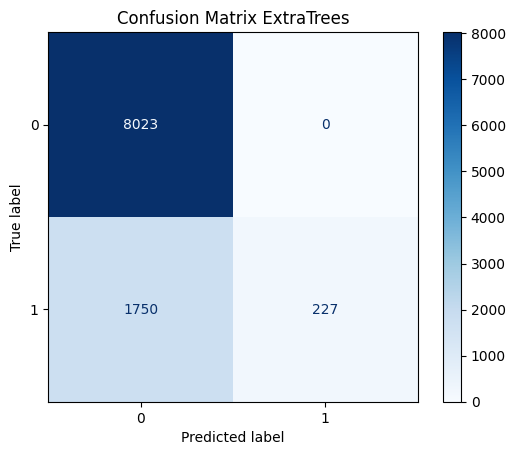

In [ ]:
cm_ET = confusion_matrix(y_test, y_pred_ET)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ET)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix ExtraTrees')
plt.show()

This matrix shows that the model is highly confident in predicting class 0 (non-default), with **zero false positives**, but it struggles to correctly identify class 1 (defaults). Out of 1,977 actual defaults, only **227 were correctly predicted** (recall ~11%). This indicates class imbalance or conservative decision boundaries.

In [ ]:
extra_trees_model = ExtraTrees_pipeline.named_steps['model']

##  Interpretation of Top Features (SHAP) Extra Trees

In [ ]:

X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

In [ ]:
explainer = shap.TreeExplainer(extra_trees_model)
shap_values = explainer.shap_values(X_test)

shap_values = shap_values[:, :, 1]

# Now plot
# shap.summary_plot(shap_values, X_test_df)

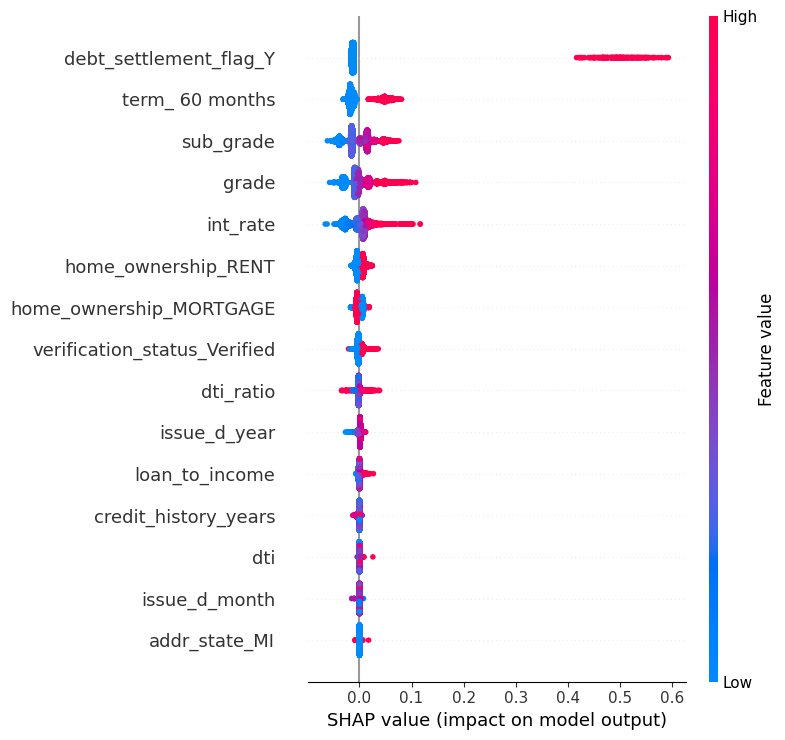

In [ ]:
shap.summary_plot(shap_values, X_test_df)
plt.title("SHAP Summary Plot ET class 1", fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation:**  
- `debt_settlement_flag_Y` dominates — high values consistently push predictions towards default.
- Red points on the right = high feature value increasing default risk.
- `term_60 months`, `grade`, `sub_grade`, and `int_rate` are also influential.
- Blue values on the left = lower values decreasing risk.

##Permutation Feature Importance(x trees)

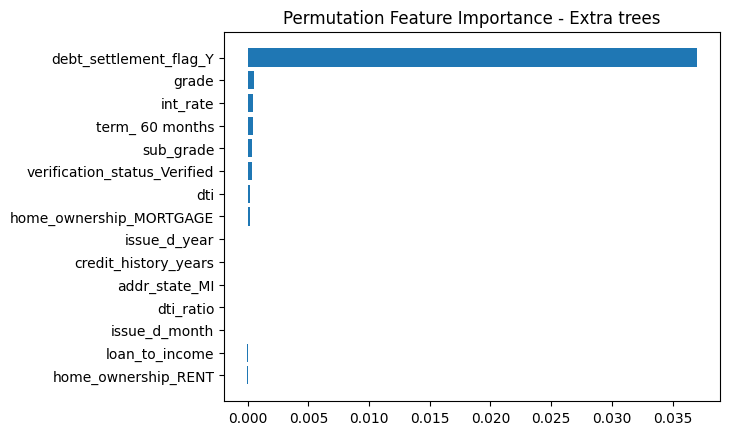

In [ ]:
result = permutation_importance(ExtraTrees_pipeline, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(df.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - Extra trees")
plt.show()

**Interpretation:**  
- `debt_settlement_flag_Y` causes the most performance drop when permuted.
- The rest of the features (e.g., `term_60 months`, `grade`, etc.) have modest importance.
- The model appears to rely on a single leading characteristic for its operation.

##**Global Surrogate Model:**

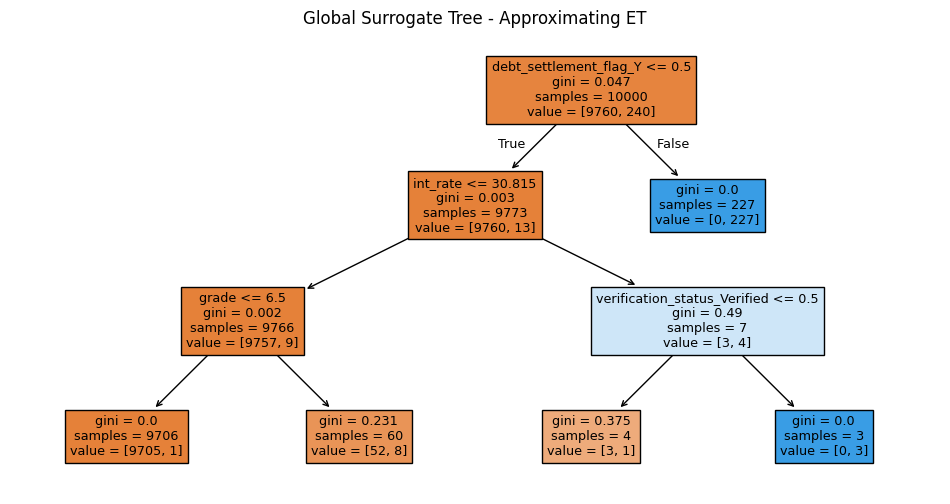

In [ ]:
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_test, y_pred_ET)

# Plot the surrogate tree
plt.figure(figsize=(12,6))
tree.plot_tree(surrogate, feature_names=X_test.columns, filled=True)
plt.title("Global Surrogate Tree - Approximating ET")
plt.show()

**Interpretation:**  
- Root split on `debt_settlement_flag_Y`, confirming it's the most decisive feature.
- Other splits include `int_rate` and `grade`, showing their conditional influence.
- The system enables users to extract "if-then rules" from the constructed model.

##**H-Statistic (Feature Interaction): ET**

The H-statistic defines the interaction between features as the share of variance that is explained by the interaction.


In [ ]:
# Fit Friedman H statistic evaluator
h_stat_et = FriedmanHStatisticMethod()
h_stat_et.fit(ExtraTrees_pipeline, X_exp_scaled_df)

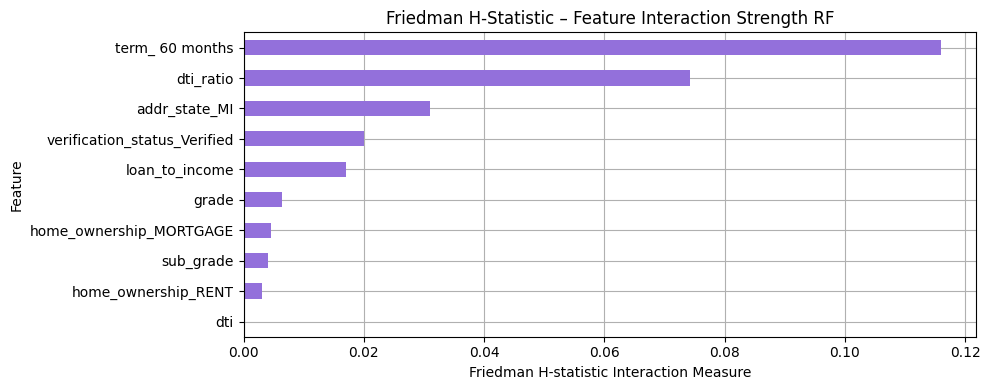

In [ ]:
# Overall interaction plot
fig, ax = plt.subplots(figsize=(10, 4))
h_stat_et.plot('bar_chart_ova',ax=ax)
ax.set_title("Friedman H-Statistic – Feature Interaction Strength RF")
plt.tight_layout()
plt.show()

**Interpretation:**  
- Features like `term_60 months`, `addr_state_MI`, and `dti_ratio` have high H values.
- The predictive capabilities of these columns remain **not independent** because they engage with additional elements within the dataset.
- For instance, `term_60 months` might only matter for certain income or grade levels.

### PDP shows the **average trend**, ICE shows the **individual sensitivity**.

##  Partial Dependence Plot (PDP)

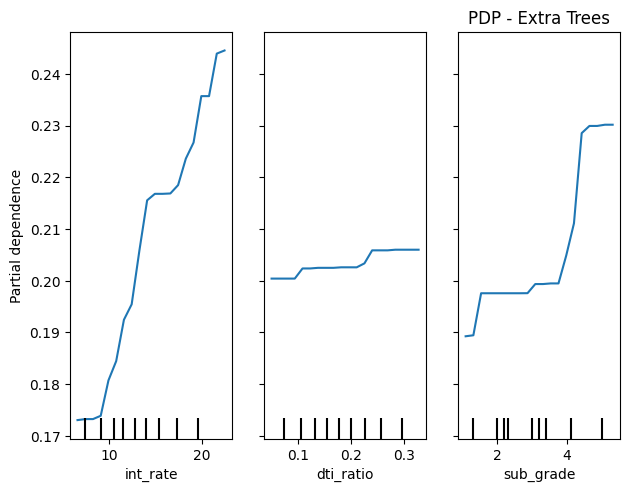

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    ExtraTrees_pipeline,
    X_test,
    features=['int_rate', 'dti_ratio','sub_grade'],
    grid_resolution=20
)
plt.tight_layout()
plt.title("PDP - Extra Trees")
plt.show()

- As `int_rate` increases, the model predicts a **higher risk of loan default**.
- Similarly, higher values of `dti_ratio` (debt-to-income ratio) and worse `sub_grade` result in higher default predictions.
- The trend is **positive monotonic**: more = riskier.
- This means these features are seen by the model as strong **global risk indicators** for default.

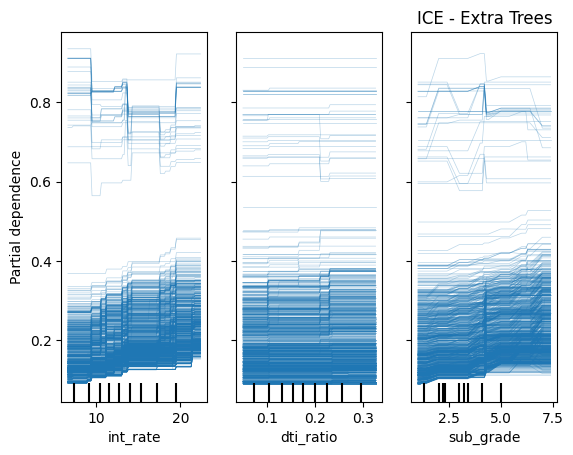

In [ ]:
# ICE is included with PDP in sklearn
PartialDependenceDisplay.from_estimator(ExtraTrees_pipeline, X_test, features=['int_rate', 'dti_ratio','sub_grade'], kind='individual')
plt.title("ICE - Extra Trees")
plt.show()

- Most lines show increasing risk as `int_rate`, `dti_ratio`, or `sub_grade` increases — **consistent with the PDP**.
- However, The slope and shape of this connection prove different for each borrower group:
  - For some borrowers, a minimal interest rate rise leads toward significant default predictions in certain circumstances..
  - For others, the effect is weaker or flat.
- This reveals **interactions**: e.g., `int_rate` matters more when `loan_to_income` is low or `term = 60 months`.

